In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Import

In [2]:
import pandas
import numexpr
import numpy
from rep_ef.estimators import MatrixNetSkyGridClassifier
from rep.metaml import FoldingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
def statistics(data):
    print 'Events:', len(numpy.unique(data.event)), 'tracks:', len(data)

## Reading initial data

In [ ]:
data_nan = pandas.read_csv('../../datasets/Tagging/Tracks.csv', sep='\t')
data = data_nan.dropna()
len(data_nan), len(data)

In [ ]:
data.head()

In [6]:
statistics(data)

Events: 1005579 tracks: 27156190


# Find good tracks to define sign B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Choose B-events

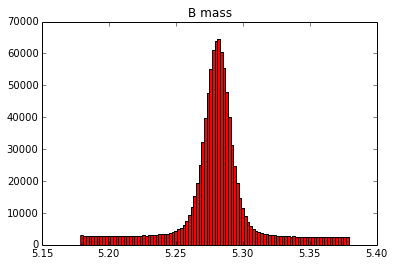

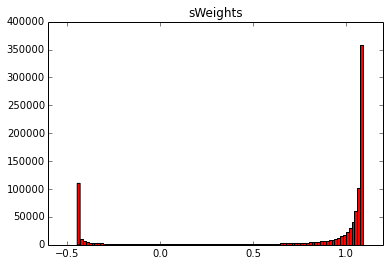

In [7]:
hist([gr['Bmass'].values[0] for _, gr in data.groupby('event')], bins=100)
title('B mass')
show()
hist([gr['N_sig_sw'].values[0] for _, gr in data.groupby('event')], bins=100, normed=True)
title('sWeights')
pass

In [8]:
sweight_threshold = 1.
data = data[data.N_sig_sw > sweight_threshold]
statistics(data)

Events: 614349 tracks: 16043904


In [449]:
data.to_csv('Tracks_Bselected.csv', index=False)

In [5]:
data = pandas.read_csv('Tracks_Bselected.csv')

In [7]:
from sklearn.cross_validation import train_test_split
id_train, id_test = train_test_split(numpy.unique(data.event), train_size=0.5, random_state=11)

In [31]:
pandas.DataFrame({'train_id': id_train}).to_csv('events_train.csv', index=False)
pandas.DataFrame({'test_id': id_test}).to_csv('events_test.csv', index=False)

In [111]:
# TEST = pandas.read_csv('Tracks_Bselected.csv')

In [10]:
data = data.ix[numpy.in1d(data.event.values, id_train), :]

## Add diff_pt and cos(diff_phi)

In [14]:
# add different between max pt in event and pt for each track
def add_diff_pt(data):
    data['diff_pt'] = 0.
    max_pt = group_max(data.event.values.astype(numpy.int64), data.partPt.values)
    data['diff_pt'] = max_pt - data['partPt'].values

# max is very similar
def group_max(groups, data):
    print len(groups), len(data)
    order = numpy.lexsort((data, groups))
    _, _groups = numpy.unique(groups, return_inverse=True)
    groups = groups[order] #this is only needed if groups is unsorted
    data = data[order]
    index = numpy.empty(len(groups), 'bool')
    index[-1] = True
    index[:-1] = groups[1:] != groups[:-1]
    return data[index][_groups]

In [15]:
# add diff pt
add_diff_pt(data)
# add cos(diff_phi)
data['cos_diff_phi'] = numpy.cos(data.diff_phi.values)

8027580 8027580


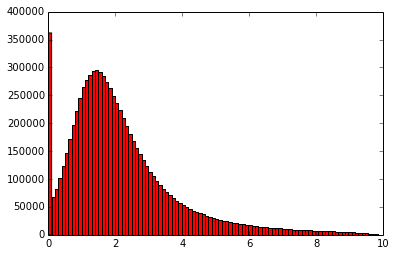

In [16]:
hist(data.diff_pt.values, bins=100)
pass

## Select protons and pions, ghost prob cut

In [17]:
threshold_mistag = 0.6
initial_cut = '(PIDNNp < {tr}) & (PIDNNpi < {tr}) & (ghostProb < 0.4)'.format(tr=threshold_mistag)
data_pid = data.query(initial_cut)

## Select muons, kaons, electrons

In [18]:
threshold_kaon = 0.7 
threshold_muon = 0.4
threshold_electron = 0.6
cut_pid = """
            ((PIDNNk > {trk}) 
                | (PIDNNm > {trm}) 
                | (PIDNNe > {tre})) """.format(trk=threshold_kaon, trm=threshold_muon,
                                               tre=threshold_electron).replace("\n", "")
    
data_pid = data_pid.query(cut_pid)

In [19]:
statistics(data_pid)

Events: 204720 tracks: 372082


In [112]:
data_their = data.query('(K_cut == 1) | (e_cut == 1) | (mu_cut == 1)')
N_pass_their = sum([gr['N_sig_sw'].values[0] for _, gr in data_their.groupby('event')])

## $\epsilon_{tag}$

In [20]:
N_pass = sum([gr['N_sig_sw'].values[0] for _, gr in data_pid.groupby('event')])
N_all = sum([gr['N_sig_sw'].values[0] for _, gr in data.groupby('event')])
eff_tag = 1. * N_pass / N_all
eff_delta = sqrt(N_pass) / N_all
eff_tag, eff_delta

(0.66645794464803998, 0.0014227294962879838)

In [113]:
statistics(data_their)
N_pass_their / N_all

Events: 76498 tracks: 82157


0.24900852935896284

## Define features

In [21]:
features = list(set(data.columns) - {'run', 'event', 'i', 'signB', 'signTrack', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi'})
features

['cos_diff_phi',
 'K_cut',
 'partPt',
 'partP',
 'nnkrec',
 'diff_eta',
 'EOverP',
 'mu_cut',
 'ptB',
 'e_cut',
 'PIDNNe',
 'PIDNNk',
 'PIDNNm',
 'proj',
 'phi',
 'diff_pt',
 'IP',
 'IPerr',
 'IPs',
 'ID',
 'veloch',
 'diff_phi',
 'ghostProb',
 'IPPU',
 'eta',
 'partlcs']

## PID pairs scatters

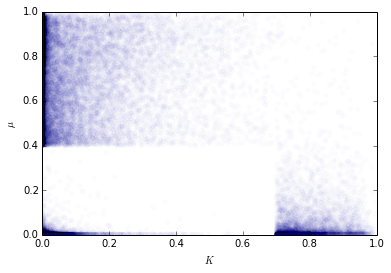

In [22]:
scatter(data_pid['PIDNNk'].values, data_pid['PIDNNm'].values, alpha=0.01)
xlabel('$K$')
ylabel('$\mu$')
ylim(0, 1)
xlim(0, 1)
pass

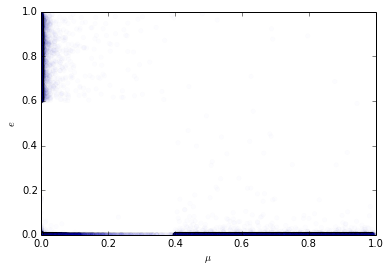

In [23]:
scatter(data_pid['PIDNNm'].values, data_pid['PIDNNe'].values, alpha=0.01)
xlabel('$\mu$')
ylabel('$e$')
ylim(0, 1)
xlim(0, 1)
pass

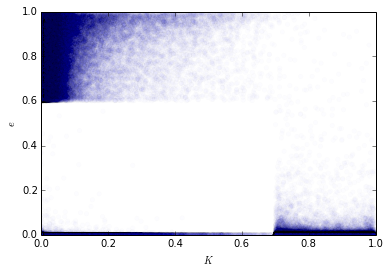

In [24]:
scatter(data_pid['PIDNNk'].values, data_pid['PIDNNe'].values, alpha=0.01)
xlabel('$K$')
ylabel('$e$')
ylim(0, 1)
xlim(0, 1)
pass

### pt

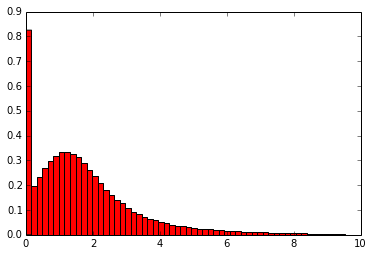

In [25]:
hist(data_pid.diff_pt.values, bins=60, normed=True)
pass

### count of tracks

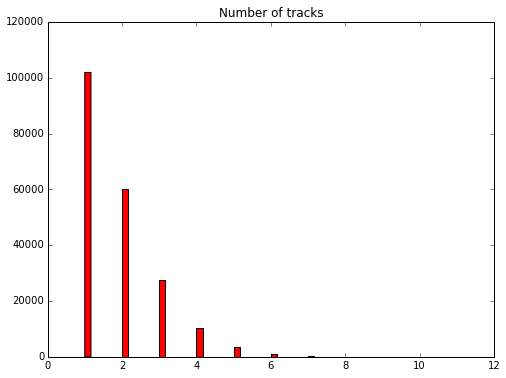

In [196]:
hist([len(gr) for num, gr in data_pid.groupby('event')], bins=60)    
title('Number of tracks')
pass

### pid histograms after selections

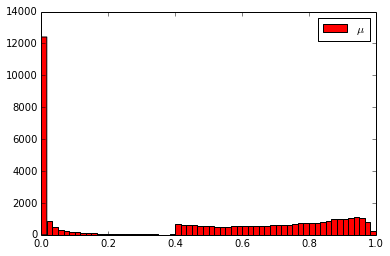

In [27]:
hist(data_pid["PIDNNm"].values, bins=60, range=(0, 1), label='$\mu$')
legend()
pass

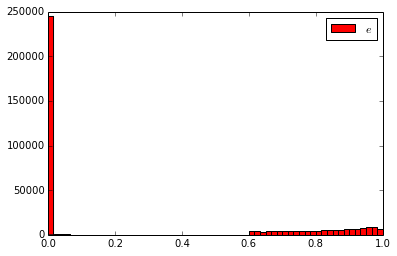

In [28]:
hist(data_pid["PIDNNe"].values, bins=60, range=(0, 1), label='$e$')
legend()
pass

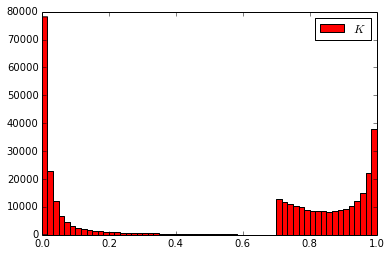

In [29]:
hist(data_pid["PIDNNk"].values, bins=60, range=(0, 1), label='$K$')
legend()
pass
#numpy.sum(data.PIDNNk > 0.5), len(data)

### define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [30]:
product_sign = (data_pid.signB.values * data_pid.signTrack.values > 0) * 1

### 2-folding training

In [14]:
import cPickle
with open('track_forest.pkl', 'r') as f:
    est_choose_RT = cPickle.load(f)

In [ ]:
base = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=100, n_jobs=8)
est_choose_RT = FoldingClassifier(base, features=features)
est_choose_RT.fit(data_pid, product_sign, data_pid.N_sig_sw)

In [ ]:
import cPickle
with open('track_forest.pkl', 'w') as f:
    cPickle.dump(est_choose_RT, f)

----

### AUC

In [ ]:
probs_RT = est_choose_RT.predict_proba(data_pid)
roc_auc_score(product_sign, probs_RT[:, 1], sample_weight=data_pid.N_sig_sw.values)

### ROC

In [ ]:
fpr, tpr, _ = roc_curve(product_sign, probs_RT[:, 1], sample_weight=data_pid.N_sig_sw.values)
plot(fpr, tpr)
plot([0, 1], [0, 1])

In [197]:
imp = numpy.sum([est.feature_importances_ for est in est_choose_RT.estimators], axis=0)
pandas.DataFrame({'importance': -sort(-imp) / max(imp), 
                  'feature': numpy.array(est_choose_RT.features)[numpy.argsort(-imp)]})

,feature,importance
0,mu_cut,1.000000
1,IPs,0.960485
2,K_cut,0.889301
3,partPt,0.752916
4,PIDNNm,0.740856
5,IP,0.587023
6,diff_pt,0.518951
7,IPerr,0.509170
8,proj,0.452092
9,PIDNNk,0.414930


## Distributions for output

In [ ]:
from rep.utils import Flattener

In [ ]:
def run_flat_probs(probs, labels, weights, label=1):
    figsize(8, 6)
    flat = Flattener(probs[:, 1][labels == label], weights[labels == label])
    flat_probs = flat(probs[:, 1])
    hist(flat_probs[labels == 1], bins=100, normed=True, histtype='step', 
         weights=weights[labels == 1], label='same sign')
    hist(flat_probs[labels == 0], bins=100, normed=True, histtype='step', 
         weights=weights[labels == 0], label='opposite sign')
    xlabel('predictions')
    legend(loc='upper center')
    show()
    return flat_probs

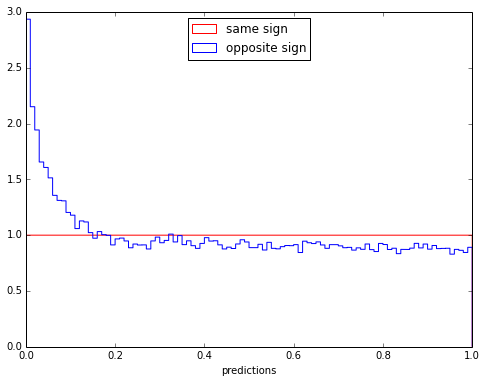

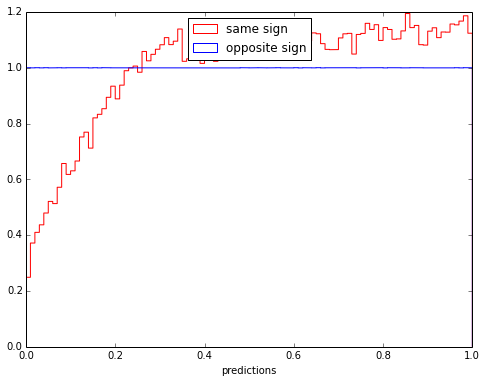

In [357]:
flat_kaon_probs = run_flat_probs(probs_RT, product_sign, data_pid.N_sig_sw.values, label=1)
flat_lepton_probs = run_flat_probs(probs_RT, product_sign, data_pid.N_sig_sw.values, label=0)

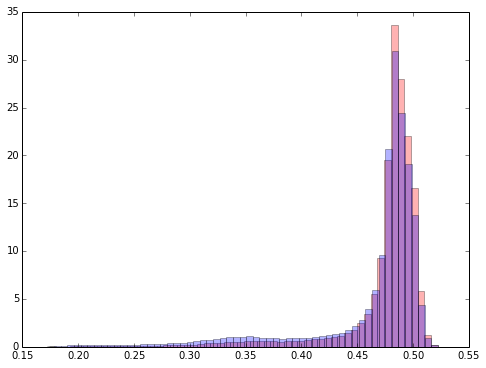

In [358]:
hist(probs_RT[:, 1][product_sign == 1], bins=60, alpha=0.3, normed=True)
hist(probs_RT[:, 1][product_sign == 0], bins=60, alpha=0.3, normed=True)
pass

## Select top-good tracks in event

In [194]:
## select the better tracks by estimator in event (probability to be necessary sign)
def get_best_tracks(data, probs, count=1):
    train_prob = data.copy()
    train_prob['target'] = (train_prob['signB'].values * train_prob['signTrack'].values > 0) * 1
    train_prob.ix[train_prob['target'] == 1, 'prediction'] = probs[train_prob['target'].values == 1]
    train_prob.ix[train_prob['target'] == 0, 'prediction'] = 1 - probs[train_prob['target'].values == 0]
    
    add_tracks = []
    others = []
    for num, group in train_prob.groupby('event'):    
        index = numpy.argsort(group['prediction'].values)[::-1]
        add_tracks.append(group.iloc[index[:count], :])
        others.append(group.iloc[index[count:], :])
    good_tracks = pandas.concat(add_tracks)
    other_tracks = pandas.concat(others)
    print len(good_tracks), len(other_tracks)
    return good_tracks, other_tracks

In [210]:
## select same sign and oposite sign tracks simultaneously

def get_pair_best_tracks(data, probs, count=1):
    train_prob = data.copy()
    train_prob['target'] = (train_prob['signB'].values * train_prob['signTrack'].values > 0) * 1
    train_prob.ix[train_prob['target'] == 1, 'prediction'] = probs[train_prob['target'].values == 1]
    train_prob.ix[train_prob['target'] == 0, 'prediction'] = 1 - probs[train_prob['target'].values == 0]
    
    add_tracks = []
    others = []
    for num, group in train_prob.groupby('event'):    
        group_plus = group[group.target == 1]
        group_minus = group[group.target == 0]
    
        index = numpy.argsort(group_plus['prediction'].values)[::-1]
        add_tracks.append(group_plus.iloc[index[:count], :])
        others.append(group_plus.iloc[index[count:], :])
        index = numpy.argsort(group_minus['prediction'].values)[::-1]
        add_tracks.append(group_minus.iloc[index[:count], :])
        others.append(group_minus.iloc[index[count:], :])

    good_tracks = pandas.concat(add_tracks)
    other_tracks = pandas.concat(others)
    print len(good_tracks), len(other_tracks)
    return good_tracks, other_tracks

# Train MN to distinguish same sign vs opposite sign

In [ ]:
from rep_ef.estimators import MatrixNetSkyGridClassifier

In [114]:
data_their_tt, data_their_te = train_test_split_group(data_their['event'], data_their, random_state=11, train_size=0.5)

In [359]:
from rep.utils import train_test_split_group
data_train, data_test, probs_RT_train, _, flat_kaon_probs_train, _, flat_lepton_probs_train, _, product_sign_train, _= \
                                            train_test_split_group(data_pid['event'],
                                                                  data_pid, probs_RT,
                                                                  flat_kaon_probs, 
                                                                  flat_lepton_probs, 
                                                                  product_sign,
                                                                  random_state=11, train_size=0.5)

In [ ]:
len(data_train), len(data_test)

--------------

In [26]:
with open('mn_full.pkl', 'r') as f:
    mn_folding = cPickle.load(f)

In [ ]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=3000, regularization=0.02, sync=False)
mn_folding = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                               features=features)
labels = (data_train['signB'].values * data_train['signTrack'].values > 0) * 1
mn_folding.fit(data_train, labels, data_train.N_sig_sw.values)

In [377]:
imp = numpy.sum([est.feature_importances_ for est in mn_folding.estimators], axis=0)
pandas.DataFrame({'importance': -sort(-imp) / max(imp), 
                  'feature': numpy.array(mn_folding.features)[numpy.argsort(-imp)]})

,feature,importance
0,IPs,1.000000
1,diff_pt,0.989973
2,cos_diff_phi,0.912616
3,ghostProb,0.880011
4,veloch,0.875979
5,ptB,0.854597
6,phi,0.845197
7,partlcs,0.832147
8,proj,0.822278
9,IP,0.780993


In [ ]:
with open('mn_full.pkl', 'w') as f:
    cPickle.dump(mn_folding, f)

---------

### Selected part of data

In [ ]:
data_selected_forest = data_train[((flat_kaon_probs_train < 0.6) & (product_sign_train == 0)) | 
                                  ((flat_lepton_probs_train > 0.4) & (product_sign_train == 1))]

In [ ]:
part2 = data_train[~(((flat_kaon_probs_train < 0.6) & (product_sign_train == 0)) | 
                                  ((flat_lepton_probs_train > 0.4) & (product_sign_train == 1)))]

In [ ]:
statistics(data_selected_forest)

In [ ]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=3000, regularization=0.02, sync=False)
mn_folding_forest = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                                      features=features)
labels = (data_selected_forest['signB'].values * data_selected_forest['signTrack'].values > 0) * 1
mn_folding_forest.fit(data_selected_forest, labels, data_selected_forest.N_sig_sw.values)

In [ ]:
with open('mn_forest_select.pkl', 'w') as f:
    cPickle.dump(mn_folding_forest, f)

----

In [211]:
selected_tracks, others_tracks = get_pair_best_tracks(data_train, probs_RT_train[:, 1], count=1)
statistics(selected_tracks)
statistics(others_tracks)

135513 49959
Events: 102360 tracks: 135513
Events: 35558 tracks: 49959


In [ ]:
with open('mn_top.pkl', 'r') as f:
    mn_folding_top = cPickle.load(f)

In [212]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=3000, regularization=0.02, sync=False)
mn_folding_top = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                                   features=features)
labels = (selected_tracks['signB'].values * selected_tracks['signTrack'].values > 0) * 1
mn_folding_top.fit(selected_tracks, labels, selected_tracks.N_sig_sw.values)

FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=3000, max_features_per_iteration=6,
              regularization=0.02, sync=False, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['cos_diff_phi', 'K_cut', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'mu_cut', 'ptB', 'e_cut', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'proj', 'phi', 'diff_pt', 'IP', 'IPerr', 'IPs', 'ID', 'veloch', 'diff_phi', 'ghostProb', 'IPPU', 'eta', 'partlcs'],
         ipc_profile=None, n_folds=2, random_state=11)

In [213]:
with open('mn_top.pkl', 'w') as f:
    cPickle.dump(mn_folding_top, f)

In [387]:
res = []
for probs in mn_folding_top.staged_predict_proba(selected_tracks):
    res.append(roc_auc_score((selected_tracks['signB'].values * selected_tracks['signTrack'].values > 0) * 1, 
                             probs[:, 1], sample_weight=selected_tracks.N_sig_sw.values))

Default prediction


--------

In [360]:
probs_sign = mn_folding.predict_proba(data_train)[:, 1]
probs_sign_sel = mn_folding_forest.predict_proba(data_selected_forest)[:, 1]
# probs_sign = mn_folding_top.predict_proba(selected_tracks)[:, 1]

KFold prediction using folds column
KFold prediction using folds column


In [361]:
labels = (data_train['signB'].values * data_train['signTrack'].values > 0) * 1
labels_sel = (data_selected_forest['signB'].values * data_selected_forest['signTrack'].values > 0) * 1
labels_test = (data_test['signB'].values * data_test['signTrack'].values > 0) * 1
weights = data_train.N_sig_sw.values
weights_sel = data_selected_forest.N_sig_sw.values
weights_test = data_test.N_sig_sw.values

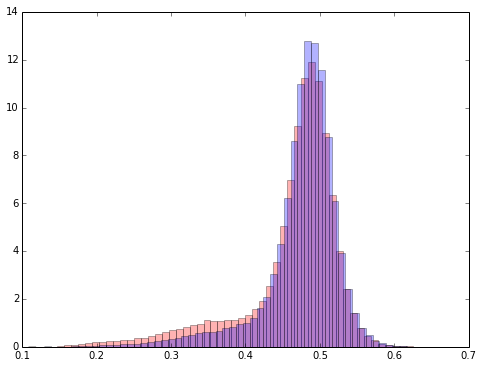

In [362]:
hist(probs_sign[labels == 0], bins=60, normed=True, alpha=0.3)
hist(probs_sign[labels == 1], bins=60, normed=True, alpha=0.3)
pass

## Isotonic calibration to probabity p(track same sign|B)

In [57]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [58]:
from scipy.special import logit

In [363]:
calib_track_probs = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
calib_track_probs.fit(probs_sign, labels)

IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=1, y_min=0)

In [324]:
part2_probs = mn_folding_forest.predict_proba(part2)[:, 1]
part2_labels = (part2['signB'].values * part2['signTrack'].values > 0) * 1
calib_track_probs_sel = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
calib_track_probs_sel.fit(numpy.concatenate([probs_sign_sel, part2_probs]), numpy.concatenate([labels_sel, part2_labels]))

KFold prediction using folds column


IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=1, y_min=0)

In [342]:
calib_track_probs_sel = LogisticRegression(C=100)
calib_track_probs_sel.fit(logit(numpy.concatenate([probs_sign_sel, part2_probs])[:, numpy.newaxis]),
                          numpy.concatenate([labels_sel, part2_labels]))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [321]:
probs_top1 = mn_folding_top.predict_proba(selected_tracks)[:, 1]
probs_top2 = mn_folding_top.predict_proba(others_tracks)[:, 1]
labels_top1 = (selected_tracks['signB'].values * selected_tracks['signTrack'].values > 0) * 1
labels_top2 = (others_tracks['signB'].values * others_tracks['signTrack'].values > 0) * 1
calib_track_probs_top = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
calib_track_probs_top.fit(numpy.concatenate([probs_top1, probs_top2]), numpy.concatenate([labels_top1, labels_top2]))

KFold prediction using folds column
KFold prediction using folds column


IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=1, y_min=0)

In [310]:
calib_track_probs_top = LogisticRegression(C=100)
calib_track_probs_top.fit(logit(numpy.concatenate([probs_top1, probs_top2])[:, numpy.newaxis]),
                          numpy.concatenate([labels_top1, labels_top2]))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [191]:
with open('tr_iso_base.pkl', 'w') as f:
    cPickle.dump(calib_track_probs_sel, f)

In [364]:
est = mn_folding
probs_sign_test = est.predict_proba(data_test)[:, 1]
roc_auc_score(labels_test, probs_sign_test)

KFold prediction using folds column


0.54449569809789078

In [365]:
probs_sign_test_calib = calib_track_probs.transform(probs_sign_test)
#calib_track_probs_top.transform(probs_sign_test)
#calib_track_probs_sel.predict_proba(logit(probs_sign_test[:, newaxis]))[:, 1]
#calib_track_probs_sel.transform(probs_sign_test)
#calib_track_probs_top.predict_proba(logit(probs_sign_test[:, newaxis]))[:, 1]

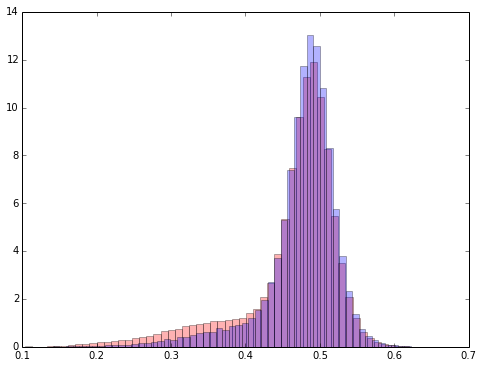

In [366]:
hist(probs_sign_test[labels_test == 0], bins=60, normed=True, alpha=0.3)
hist(probs_sign_test[labels_test == 1], bins=60, normed=True, alpha=0.3)
pass

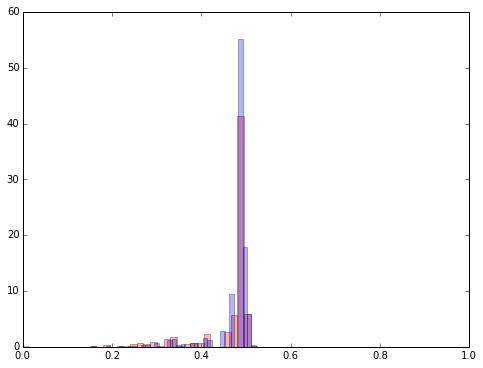

In [367]:
hist(probs_sign_test_calib[labels_test == 0], bins=60, normed=True, alpha=0.3)
hist(probs_sign_test_calib[labels_test == 1], bins=60, normed=True, alpha=0.3)
pass

## Compute p(B+)

In [329]:
statistics(data_test)

Events: 102360 tracks: 186610


In [330]:
def p_B_compute(data, probs):
    data['temp'] = probs
    probs_new = []
    labels_true = []
    weights = []
    event_id = []
    for _, gr in data.groupby('event'):
        p_i = gr['temp'].values
        signs = gr['signTrack'].values
        p_1 = numpy.prod(p_i[signs == 1] / (1 - p_i[signs == 1]))
        p_2 = numpy.prod((1 - p_i[signs == -1]) / p_i[signs == -1])
        probs_new.append(p_1 * p_2)
        labels_true.append(gr['signB'].values[0])
        weights.append(gr['N_sig_sw'].values[0])
    probs_new = numpy.array(probs_new)
    return labels_true, weights, probs_new / (1. + probs_new)

In [331]:
# def p_B_compute(data, probs):
#     _, data_ids = numpy.unique(data.event, return_inverse=True)
#     log_prob = numpy.log(p) - numpy.log(1 - p)
#     log_prob *= data.signTrack.values
#     result_logprob = numpy.bincount(data_ids, weights=log_prob)
#     result_id = numpy.bincount(data_ids, weights=data_ids) / numpy.bincount(data_ids)
#     result_weight = numpy.bincount(data_ids, weights=data.N_sig_sw) / numpy.bincount(data_ids)
#     return result_id, result_weight, result_we§

    
    
#     data['temp'] = probs
#     probs_new = []
#     labels_true = []
#     weights = []
#     event_id = []
#     for _, gr in data.groupby('event'):
#         p_i = gr['temp'].values
#         signs = gr['signTrack'].values
#         p_1 = numpy.prod(p_i[signs == 1] / (1 - p_i[signs == 1]))
#         p_2 = numpy.prod((1 - p_i[signs == 0]) / p_i[signs == 0])
#         probs_new.append(p_1 * p_2)
#         labels_true.append(gr['signB'].values[0])
#         weights.append(gr['N_sig_sw'].values[0])
#     probs_new = numpy.array(probs_new)
#     return labels_true, weights, probs_new / (1. + probs_new)

In [368]:
y_true, sample_weights, pB = p_B_compute(data_test, probs_sign_test_calib)

In [369]:
sum(numpy.isnan(pB))

2

In [370]:
pB[numpy.where(numpy.isnan(pB))] = 0.5

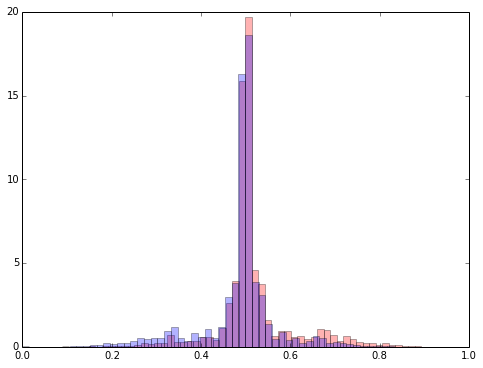

In [371]:
hist(pB[numpy.array(y_true) == 1], bins=60, normed=True, alpha=0.3)
hist(pB[numpy.array(y_true) == -1], bins=60, normed=True, alpha=0.3)
pass

In [380]:
from rep.utils import train_test_split
from sklearn.metrics import roc_auc_score
aucs = []
D2 = []
isos = []
for i in range(100):
    p_train, p_test, y_train, y_test, w_train, w_test = train_test_split(pB, y_true, sample_weights, test_size=0.5)
    calib_B_probs = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
    calib_B_probs.fit(p_train, (y_train > 0) * 1., w_train)
    pB_calib = calib_B_probs.transform(p_test)
    event_probs = numpy.max([pB_calib, 1 - pB_calib], axis=0)
    alpha = (1 - 2 * (1 - pB_calib))**2
    D2.append(numpy.mean(alpha))
#     D2.append(sum(alpha * w_test) / sum(w_test))
    aucs.append(roc_auc_score(y_test, pB_calib, sample_weight=w_test))
    isos.append(calib_B_probs)

In [382]:
from collections import OrderedDict
result = OrderedDict()
result['$\epsilon_{tag}, \%$'] = [eff_tag * 100]
result['$\Delta \epsilon_{tag}, \%$'] = [eff_delta * 100]
result['$D^2$'] = [numpy.mean(D2)]
result['$\Delta D^2$'] = [numpy.var(D2)]
result['$\epsilon, \%$'] = [numpy.mean(D2) * eff_tag * 100]
result['$\Delta \epsilon, \%$'] = [sqrt((numpy.var(D2) / numpy.mean(D2))**2 + (eff_delta / eff_tag)**2) * numpy.mean(D2) * eff_tag * 100]
pandas.DataFrame(result)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,66.645794,0.142273,0.029157,0.000002,1.943183,0.00415


In [385]:
1. * sum(data.mu_cut == 1) / len(data)

0.0022082620166974354

In [506]:
def compare_bins_iso(s=True):
    if s:
        a = numpy.linspace(0, 1, 100)
        label = 'uniform bins'
    else:
        a = numpy.percentile(p_train, numpy.linspace(0., 100, 100))
        a = numpy.array(list(a) + [1.])
        label = 'percentile bins'
    a = numpy.unique(a)
    bins_index = numpy.searchsorted(numpy.unique(a), p_train)
    n_sig = numpy.bincount(bins_index, (y_train > 0)*1, minlength=len(a) - 1)
    n_bck = numpy.bincount(bins_index, (y_train < 0)*1, minlength=len(a) - 1)
    p_bck = n_bck / (n_bck + n_sig)
    p_err = numpy.sqrt(n_sig * n_bck) / (n_sig + n_bck)**1.5
    errorbar((a[1:] - a[:-1]) / 2 + a[:-1], p_bck, xerr=(a[1:] - a[:-1]) / 2, yerr=p_err,  fmt='.', label=label)
    for i in range(1):
        plot(x, 1 - isos[i].transform(x), label='isotonic')
    ylim(0, 1)
    xlabel('BDT output', fontsize=16)
    ylabel('Probability to be wrong tagged', fontsize=16)
    legend()



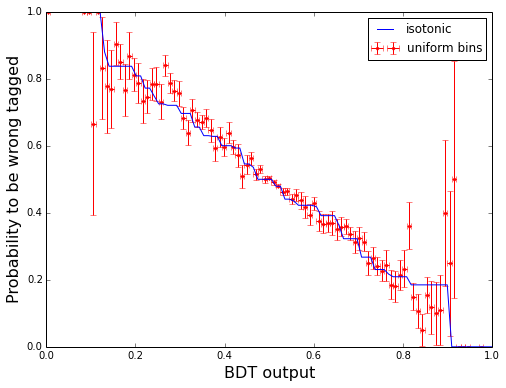

In [507]:
compare_bins_iso()

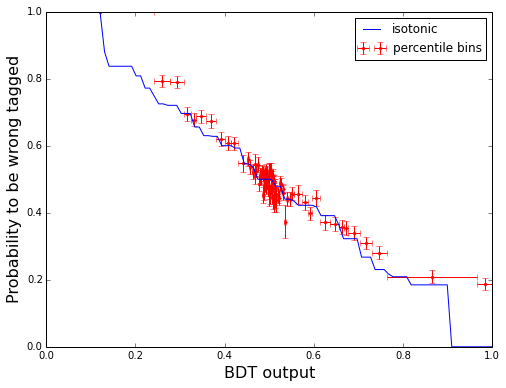

In [508]:
compare_bins_iso(False)

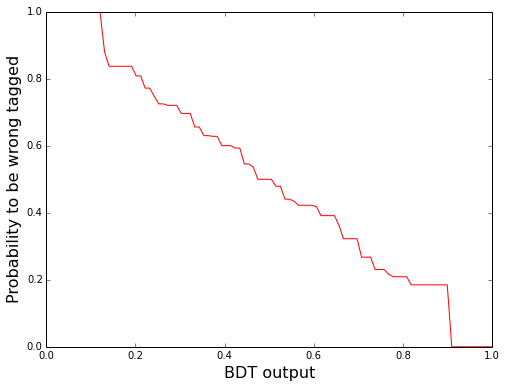

In [430]:
x = numpy.linspace(0, 1, 100)
for i in range(1):
    plot(x, 1 - isos[i].transform(x))
xlabel('BDT output', fontsize=16)
ylabel('Probability to be wrong tagged', fontsize=16)
legend()

In [190]:
import cPickle
with open('tr_iso.pkl', 'w') as f:
    cPickle.dump(isos, f)

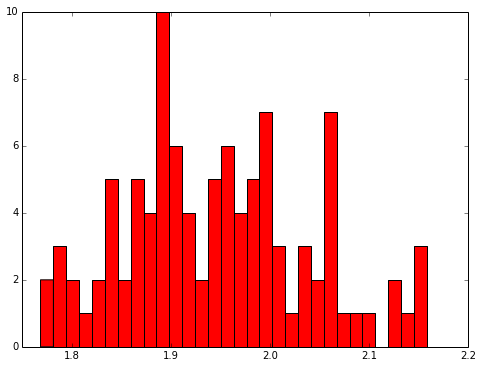

In [373]:
hist(numpy.array(D2) * eff_tag * 100, bins=30)
pass

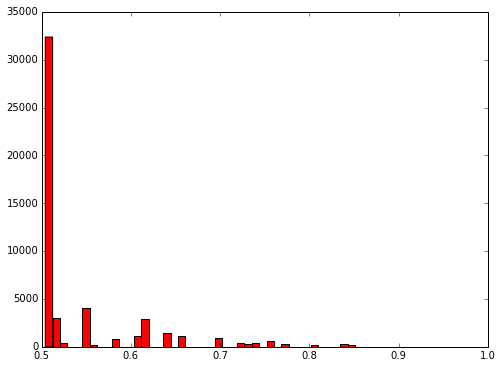

In [374]:
hist(event_probs, bins=60)
pass

In [375]:
numpy.mean(aucs), numpy.var(aucs)

(0.58015353862858732, 4.8144889433357559e-06)

## Compute D2

In [187]:
labels = (pB_calib > 0.5) * 1.
labels[labels == 0] = -1

## Iso median, selection bounds

In [341]:
from collections import OrderedDict
result = OrderedDict()
result['$\epsilon_{tag}, \%$'] = [eff_tag * 100]
result['$\Delta \epsilon_{tag}, \%$'] = [eff_delta * 100]
result['$D^2$'] = [numpy.mean(D2)]
result['$\Delta D^2$'] = [numpy.var(D2)]
result['$\epsilon, \%$'] = [numpy.mean(D2) * eff_tag * 100]
result['$\Delta \epsilon, \%$'] = [sqrt((numpy.var(D2) / numpy.mean(D2))**2 + (eff_delta / eff_tag)**2) * numpy.mean(D2) * eff_tag * 100]
pandas.DataFrame(result)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,66.645794,0.142273,0.029531,0.000002,1.968119,0.004204


## Log median, selection bounds

In [355]:
from collections import OrderedDict
result = OrderedDict()
result['$\epsilon_{tag}, \%$'] = [eff_tag * 100]
result['$\Delta \epsilon_{tag}, \%$'] = [eff_delta * 100]
result['$D^2$'] = [numpy.mean(D2)]
result['$\Delta D^2$'] = [numpy.var(D2)]
result['$\epsilon, \%$'] = [numpy.mean(D2) * eff_tag * 100]
result['$\Delta \epsilon, \%$'] = [sqrt((numpy.var(D2) / numpy.mean(D2))**2 + (eff_delta / eff_tag)**2) * numpy.mean(D2) * eff_tag * 100]
pandas.DataFrame(result)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,66.645794,0.142273,0.028222,0.000001,1.880852,0.004016


## Iso median, top selection

In [308]:
from collections import OrderedDict
result = OrderedDict()
result['$\epsilon_{tag}, \%$'] = [eff_tag * 100]
result['$\Delta \epsilon_{tag}, \%$'] = [eff_delta * 100]
result['$D^2$'] = [numpy.mean(D2)]
result['$\Delta D^2$'] = [numpy.var(D2)]
result['$\epsilon, \%$'] = [numpy.mean(D2) * eff_tag * 100]
result['$\Delta \epsilon, \%$'] = [sqrt((numpy.var(D2) / numpy.mean(D2))**2 + (eff_delta / eff_tag)**2) * numpy.mean(D2) * eff_tag * 100]
pandas.DataFrame(result)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,66.645794,0.142273,0.029017,0.000002,1.933875,0.00413


## Log median , top selection

In [320]:
from collections import OrderedDict
result = OrderedDict()
result['$\epsilon_{tag}, \%$'] = [eff_tag * 100]
result['$\Delta \epsilon_{tag}, \%$'] = [eff_delta * 100]
result['$D^2$'] = [numpy.mean(D2)]
result['$\Delta D^2$'] = [numpy.var(D2)]
result['$\epsilon, \%$'] = [numpy.mean(D2) * eff_tag * 100]
result['$\Delta \epsilon, \%$'] = [sqrt((numpy.var(D2) / numpy.mean(D2))**2 + (eff_delta / eff_tag)**2) * numpy.mean(D2) * eff_tag * 100]
pandas.DataFrame(result)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,66.645794,0.142273,0.029878,0.000001,1.991215,0.004251


---------------------

In [376]:
from collections import OrderedDict
result = OrderedDict()
result['$\epsilon_{tag}, \%$'] = [eff_tag * 100]
result['$\Delta \epsilon_{tag}, \%$'] = [eff_delta * 100]
result['$D^2$'] = [numpy.mean(D2)]
result['$\Delta D^2$'] = [numpy.var(D2)]
result['$\epsilon, \%$'] = [numpy.mean(D2) * eff_tag * 100]
result['$\Delta \epsilon, \%$'] = [sqrt((numpy.var(D2) / numpy.mean(D2))**2 + (eff_delta / eff_tag)**2) * numpy.mean(D2) * eff_tag * 100]
pandas.DataFrame(result)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,66.645794,0.142273,0.029199,0.000002,1.946008,0.004156
